## Mount Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set Project Directory and Change Path

In [ ]:
import os

project_dir = '/content/drive/MyDrive/Skin-Cancer-Detection'
os.chdir(project_dir)

## Copy Images and Metadata to Local Colab Disk

In [ ]:
import shutil

local_data_dir = '/content/data'
drive_data_dir = os.path.join(project_dir, 'data')

# Copy image folder
if not os.path.exists(f"{local_data_dir}/HAM10000"):
    os.makedirs(local_data_dir, exist_ok=True)
    print("Copying HAM10000 images to local disk...")
    shutil.copytree(os.path.join(drive_data_dir, 'HAM10000'), f"{local_data_dir}/HAM10000")
else:
    print("HAM10000 images already copied.")

# Copy CSVs
for fn in ['train_meta.csv', 'val_meta.csv', 'test_meta.csv']:
    src = os.path.join(drive_data_dir, fn)
    dst = os.path.join(local_data_dir, fn)
    if not os.path.exists(dst):
        shutil.copy(src, dst)
        print(f"Copied {fn} to local disk.")
    else:
        print(f"{fn} already exists in local disk.")

Copying HAM10000 images to local disk...
Copied train_meta.csv to local disk.
Copied val_meta.csv to local disk.
Copied test_meta.csv to local disk.


## Imports and Helper Functions

### Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import timm
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
import albumentations as A
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau

### Helper Functions

In [ ]:
def gray_world(img, **kwargs):
    img = img.astype(np.float32)
    avgR, avgG, avgB = np.mean(img[:,:,0]), np.mean(img[:,:,1]), np.mean(img[:,:,2])
    avgGray = (avgR + avgG + avgB) / 3
    img[:,:,0] *= avgGray / (avgR + 1e-8)
    img[:,:,1] *= avgGray / (avgG + 1e-8)
    img[:,:,2] *= avgGray / (avgB + 1e-8)
    return np.clip(img, 0, 255).astype(np.uint8)

def get_torch_train_aug(img_size=224):
    return A.Compose([
        A.Lambda(image=gray_world, p=1.0),
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=180, p=0.7),
        A.Affine(
            scale=(0.9, 1.1),
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
            shear=(-8, 8),
            border_mode=cv2.BORDER_REFLECT_101, p=0.5
        ),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=0.6),
        A.RandomCrop(img_size, img_size, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

def get_torch_val_aug(img_size=224):
    return A.Compose([
        A.Lambda(image=gray_world, p=1.0),
        A.Resize(img_size, img_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

## Custom Dataset Class

In [ ]:
class HAM10000TorchDataset(Dataset):
    def __init__(self, df, img_dir, img_size=224, augment_fn=None, label_encoder=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.img_size = img_size
        self.augment_fn = augment_fn
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image_id'] + ".jpg")
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.augment_fn:
            img = self.augment_fn(image=img)['image']
        img = np.transpose(img, (2, 0, 1))
        label = self.label_encoder.transform([row['dx']])[0]
        return torch.tensor(img, dtype=torch.float32), label

## Load Data Splits, LabelEncoder, and Compute Class Weights

In [ ]:
train_df = pd.read_csv("/content/data/train_meta.csv")
val_df = pd.read_csv("/content/data/val_meta.csv")

In [ ]:
label_encoder = LabelEncoder().fit(train_df['dx'])

In [ ]:
classes = sorted(train_df['dx'].unique())
class_indices = {c: i for i, c in enumerate(classes)}
class_weights_np = compute_class_weight(class_weight='balanced', classes=np.array(classes), y=train_df['dx'])
class_weights = torch.tensor(class_weights_np, dtype=torch.float32)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Model Configurations

In [ ]:
all_models = {
    "vit_base": {
        "model_name": "vit_base_patch16_224",
        "img_size": 224, "batch_size": 16, "epochs": 60, "lr": 1e-4
    },
    "convnext_base": {
        "model_name": "convnext_base",
        "img_size": 224, "batch_size": 16, "epochs": 60, "lr": 1e-4
    },
    "swin_base": {
        "model_name": "swin_base_patch4_window7_224",
        "img_size": 224, "batch_size": 16, "epochs": 60, "lr": 1e-4
    }
}

num_classes = len(label_encoder.classes_)

## Training Loop for All Models

In [ ]:
import gc

def reset_gpu_cache():
    torch.cuda.empty_cache()
    gc.collect()

def full_reset():
    reset_gpu_cache()
    for var in ["model", "optimizer", "scheduler", "criterion"]:
        if var in globals():
            del globals()[var]
    gc.collect()

In [ ]:
os.makedirs('/content/models', exist_ok=True)

In [ ]:
from tqdm import tqdm

all_histories = {}
for name, mcfg in all_models.items():
    print(f"\n--- Training {name} ---")
    reset_gpu_cache()

    img_size = mcfg["img_size"]
    batch_size = mcfg["batch_size"]
    lr = mcfg["lr"]
    epochs = mcfg["epochs"]

    train_dataset = HAM10000TorchDataset(
        train_df, "/content/data/HAM10000", img_size=img_size,
        augment_fn=get_torch_train_aug(img_size), label_encoder=label_encoder
    )
    val_dataset = HAM10000TorchDataset(
        val_df, "/content/data/HAM10000", img_size=img_size,
        augment_fn=get_torch_val_aug(img_size), label_encoder=label_encoder
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = timm.create_model(mcfg["model_name"], pretrained=True, num_classes=num_classes, in_chans=3)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-7)

    best_val_loss = float("inf")
    best_val_acc = 0.0
    patience = 7
    epochs_no_improve = 0

    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct, total_seen = 0, 0, 0

        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total_seen += imgs.size(0)
        train_loss_epoch = total_loss / total_seen
        train_acc = total_correct / total_seen

        model.eval()
        val_correct, val_seen, val_loss = 0, 0, 0

        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False):
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_seen += imgs.size(0)
        val_loss_epoch = val_loss / val_seen
        val_acc = val_correct / val_seen
        scheduler.step(val_loss_epoch)

        print(f"Epoch {epoch+1}/{epochs} | train_acc: {train_acc:.4f} | val_acc: {val_acc:.4f} | train_loss: {train_loss_epoch:.4f} | val_loss: {val_loss_epoch:.4f}")

        train_loss_list.append(train_loss_epoch)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss_epoch)
        val_acc_list.append(val_acc)

        if val_loss_epoch < best_val_loss:
            best_val_loss = val_loss_epoch
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"/content/models/{name}_best_model.pth")
            print(f"Best model saved: /content/models/{name}_best_model.pth")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1} (no val_loss improve for {patience} epochs)")
                break

    history_dict = {
        "loss": train_loss_list,
        "accuracy": train_acc_list,
        "val_loss": val_loss_list,
        "val_accuracy": val_acc_list
    }

    all_histories[name] = history_dict
    full_reset()


--- Training vit_base ---


Epoch 1/60 | train_acc: 0.3879 | val_acc: 0.3045 | train_loss: 1.7574 | val_loss: 1.4553
Best model saved: /content/models/vit_base_best_model.pth


Epoch 2/60 | train_acc: 0.5298 | val_acc: 0.5193 | train_loss: 1.4292 | val_loss: 1.2692
Best model saved: /content/models/vit_base_best_model.pth


Epoch 3/60 | train_acc: 0.5566 | val_acc: 0.5113 | train_loss: 1.3007 | val_loss: 1.1530
Best model saved: /content/models/vit_base_best_model.pth


Epoch 4/60 | train_acc: 0.5952 | val_acc: 0.6682 | train_loss: 1.2190 | val_loss: 0.8474
Best model saved: /content/models/vit_base_best_model.pth


Epoch 5/60 | train_acc: 0.6011 | val_acc: 0.5964 | train_loss: 1.2039 | val_loss: 1.0513


Epoch 6/60 | train_acc: 0.6011 | val_acc: 0.6469 | train_loss: 1.1183 | val_loss: 0.8317
Best model saved: /content/models/vit_base_best_model.pth


Epoch 7/60 | train_acc: 0.5998 | val_acc: 0.6051 | train_loss: 1.1023 | val_loss: 0.9867


Epoch 8/60 | train_acc: 0.6240 | val_acc: 0.6562 | train_loss: 1.0725 | val_loss: 0.8500


Epoch 9/60 | train_acc: 0.6420 | val_acc: 0.5991 | train_loss: 1.0343 | val_loss: 0.9829


Epoch 10/60 | train_acc: 0.6293 | val_acc: 0.6749 | train_loss: 1.0711 | val_loss: 0.8619


Epoch 11/60 | train_acc: 0.6807 | val_acc: 0.6549 | train_loss: 0.9027 | val_loss: 0.8413


Epoch 12/60 | train_acc: 0.6782 | val_acc: 0.6656 | train_loss: 0.8404 | val_loss: 0.8332


Epoch 13/60 | train_acc: 0.6910 | val_acc: 0.6715 | train_loss: 0.8117 | val_loss: 0.8182
Best model saved: /content/models/vit_base_best_model.pth


Epoch 14/60 | train_acc: 0.7004 | val_acc: 0.6709 | train_loss: 0.7716 | val_loss: 0.7827
Best model saved: /content/models/vit_base_best_model.pth


Epoch 15/60 | train_acc: 0.7028 | val_acc: 0.6822 | train_loss: 0.7599 | val_loss: 0.7459
Best model saved: /content/models/vit_base_best_model.pth


Epoch 16/60 | train_acc: 0.7125 | val_acc: 0.6855 | train_loss: 0.7344 | val_loss: 0.7515


Epoch 17/60 | train_acc: 0.7212 | val_acc: 0.6981 | train_loss: 0.6910 | val_loss: 0.7224
Best model saved: /content/models/vit_base_best_model.pth


Epoch 18/60 | train_acc: 0.7270 | val_acc: 0.6383 | train_loss: 0.6718 | val_loss: 0.8890


Epoch 19/60 | train_acc: 0.7344 | val_acc: 0.6988 | train_loss: 0.6832 | val_loss: 0.7278


Epoch 20/60 | train_acc: 0.7344 | val_acc: 0.6915 | train_loss: 0.6495 | val_loss: 0.7394


Epoch 21/60 | train_acc: 0.7370 | val_acc: 0.6576 | train_loss: 0.6323 | val_loss: 0.9008


Epoch 22/60 | train_acc: 0.7527 | val_acc: 0.7035 | train_loss: 0.5775 | val_loss: 0.7797


Epoch 23/60 | train_acc: 0.7752 | val_acc: 0.7301 | train_loss: 0.4937 | val_loss: 0.7703


Epoch 24/60 | train_acc: 0.7793 | val_acc: 0.7154 | train_loss: 0.4706 | val_loss: 0.7813
Early stopping at epoch 24 (no val_loss improve for 7 epochs)

--- Training convnext_base ---


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

Epoch 1/60 | train_acc: 0.5677 | val_acc: 0.6070 | train_loss: 1.3210 | val_loss: 1.0097
Best model saved: /content/models/convnext_base_best_model.pth


Epoch 2/60 | train_acc: 0.7064 | val_acc: 0.7427 | train_loss: 0.8148 | val_loss: 0.7102
Best model saved: /content/models/convnext_base_best_model.pth


Epoch 3/60 | train_acc: 0.7589 | val_acc: 0.7314 | train_loss: 0.6057 | val_loss: 0.7031
Best model saved: /content/models/convnext_base_best_model.pth


Epoch 4/60 | train_acc: 0.7973 | val_acc: 0.6908 | train_loss: 0.4883 | val_loss: 0.7712


Epoch 5/60 | train_acc: 0.8313 | val_acc: 0.8085 | train_loss: 0.3642 | val_loss: 0.5372
Best model saved: /content/models/convnext_base_best_model.pth


Epoch 6/60 | train_acc: 0.8570 | val_acc: 0.7500 | train_loss: 0.3102 | val_loss: 0.6965


Epoch 7/60 | train_acc: 0.8524 | val_acc: 0.7633 | train_loss: 0.3287 | val_loss: 0.6777


Epoch 8/60 | train_acc: 0.8802 | val_acc: 0.7866 | train_loss: 0.2560 | val_loss: 0.5600


Epoch 9/60 | train_acc: 0.8847 | val_acc: 0.6902 | train_loss: 0.2570 | val_loss: 0.8772


Epoch 10/60 | train_acc: 0.9216 | val_acc: 0.8172 | train_loss: 0.1478 | val_loss: 0.5755


Epoch 11/60 | train_acc: 0.9377 | val_acc: 0.8138 | train_loss: 0.1131 | val_loss: 0.5668


Epoch 12/60 | train_acc: 0.9514 | val_acc: 0.8059 | train_loss: 0.0909 | val_loss: 0.6542
Early stopping at epoch 12 (no val_loss improve for 7 epochs)

--- Training swin_base ---


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Epoch 1/60 | train_acc: 0.4747 | val_acc: 0.5884 | train_loss: 1.5156 | val_loss: 1.0709
Best model saved: /content/models/swin_base_best_model.pth


Epoch 2/60 | train_acc: 0.6263 | val_acc: 0.6170 | train_loss: 1.0950 | val_loss: 0.9749
Best model saved: /content/models/swin_base_best_model.pth


Epoch 3/60 | train_acc: 0.6716 | val_acc: 0.7886 | train_loss: 0.9569 | val_loss: 0.6142
Best model saved: /content/models/swin_base_best_model.pth


Epoch 4/60 | train_acc: 0.7095 | val_acc: 0.7055 | train_loss: 0.8226 | val_loss: 0.8177


Epoch 5/60 | train_acc: 0.7210 | val_acc: 0.6024 | train_loss: 0.7673 | val_loss: 1.0387


Epoch 6/60 | train_acc: 0.7426 | val_acc: 0.8165 | train_loss: 0.7124 | val_loss: 0.5100
Best model saved: /content/models/swin_base_best_model.pth


Epoch 7/60 | train_acc: 0.7446 | val_acc: 0.7061 | train_loss: 0.6526 | val_loss: 0.7743


Epoch 8/60 | train_acc: 0.7602 | val_acc: 0.6303 | train_loss: 0.6099 | val_loss: 0.9017


Epoch 9/60 | train_acc: 0.7683 | val_acc: 0.7008 | train_loss: 0.5901 | val_loss: 0.7176


Epoch 10/60 | train_acc: 0.7846 | val_acc: 0.7194 | train_loss: 0.5496 | val_loss: 0.6893


Epoch 11/60 | train_acc: 0.8196 | val_acc: 0.7261 | train_loss: 0.3795 | val_loss: 0.7171


Epoch 12/60 | train_acc: 0.8424 | val_acc: 0.8125 | train_loss: 0.3279 | val_loss: 0.5123


Epoch 13/60 | train_acc: 0.8366 | val_acc: 0.7832 | train_loss: 0.3321 | val_loss: 0.5659
Early stopping at epoch 13 (no val_loss improve for 7 epochs)


## Model Training Results

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_model_history(history_dict, model_name="Model"):
    if isinstance(history_dict, dict):
        hist_df = pd.DataFrame(history_dict)
    else:
        hist_df = history_dict

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    axes[0].plot(hist_df['loss'], label='Train Loss', linewidth=2)
    axes[0].plot(hist_df['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_title(f'{model_name} Loss Curve', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    axes[1].plot(hist_df['accuracy'], label='Train Acc', linewidth=2)
    axes[1].plot(hist_df['val_accuracy'], label='Val Acc', linewidth=2)
    axes[1].set_title(f'{model_name} Accuracy Curve', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.suptitle(f"Training Results for {model_name}", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


### ViT Base Metrics

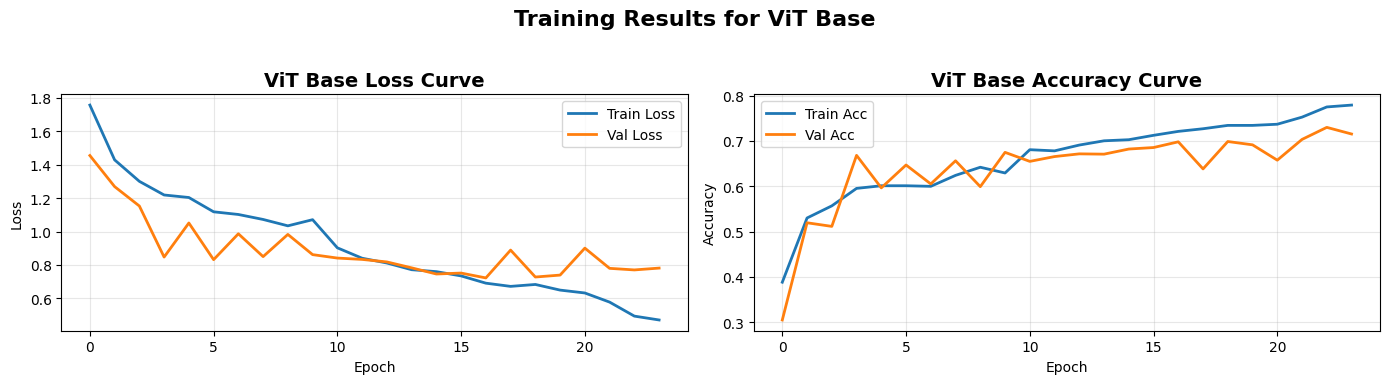

In [ ]:
plot_model_history(all_histories['vit_base'], model_name='ViT Base')

### ConvNeXt Base Metrics

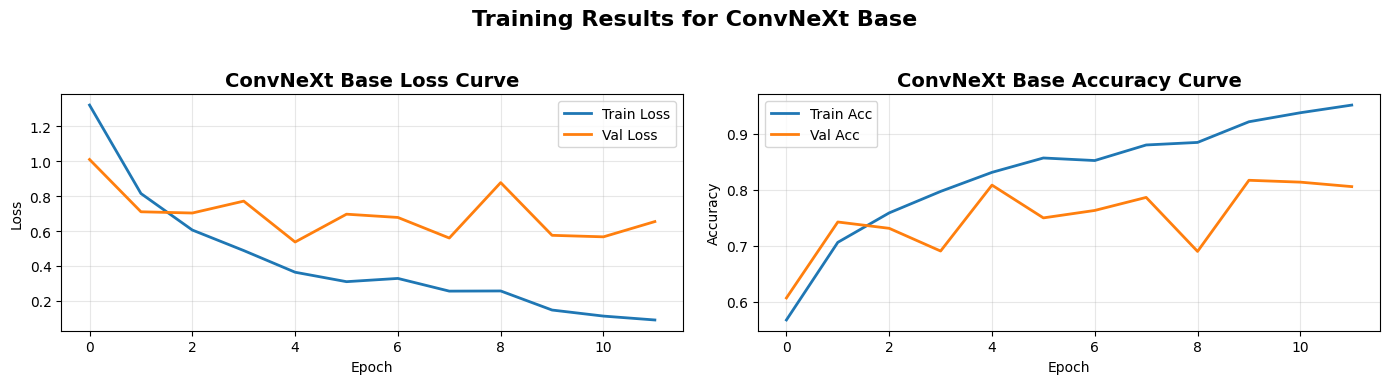

In [ ]:
plot_model_history(all_histories['convnext_base'], model_name='ConvNeXt Base')

### Swin Base Metrics

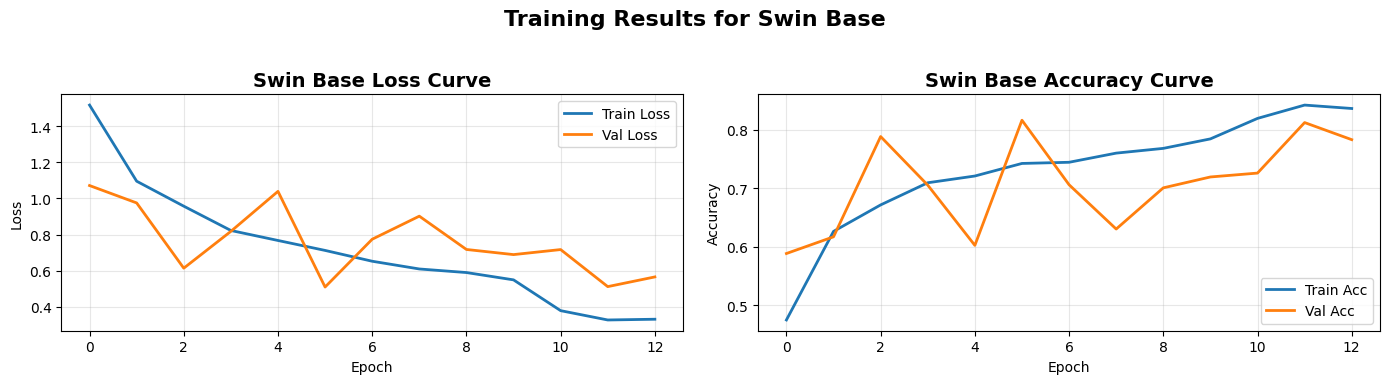

In [ ]:
plot_model_history(all_histories['swin_base'], model_name='Swin Base')

## Save All Trained Models from Colab Local to Google Drive

In [ ]:
import shutil

src_dir = '/content/models'
dst_dir = '/content/drive/MyDrive/Skin-Cancer-Detection/models'

os.makedirs(dst_dir, exist_ok=True)

for fname in os.listdir(src_dir):
    src_path = os.path.join(src_dir, fname)
    dst_path = os.path.join(dst_dir, fname)
    if os.path.isfile(src_path):
        shutil.copy2(src_path, dst_path)
        print(f"Copied {fname} to Google Drive.")

print("All models copied to Google Drive!")

Copied convnext_base_best_model.pth to Google Drive.
Copied swin_base_best_model.pth to Google Drive.
Copied vit_base_best_model.pth to Google Drive.
All models copied to Google Drive!
